#  Intel Image Classification. 
## Image Scene Classification of Multiclass. 

## Modeling with ResNet50

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Image preprocessing

In [3]:
train_path = 'Dataset - Large\seg_train'
valid_path = 'Dataset - Large\seg_test'
test_path = 'Dataset - Large\seg_pred'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(150,150), batch_size=256)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(150,150), batch_size=256)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(150,150),class_mode = None, batch_size=256, shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 84 images belonging to 1 classes.


**Observations:**
1. Rescaling should be done to validation and test set as well.
2. model will be trained on images of size 150 * 150
3. Test batches are not shuffled. This will help in predicting class for each image in test set.

## Pretrained InceptionV3 model

In [5]:
from tensorflow.keras.applications import ResNet50
image_width, image_height = 150,150
ResNet = ResNet50(input_shape=(image_width,image_height,3),include_top=False, weights="imagenet")
ResNet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

**Observations:**
1. making include_top=False, gives us the flexibility to train the model with images size pf our choice
2. weights are imported from imagenet

## Finetuning the model

In [6]:
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
x = ResNet.layers[-1].output
flatten=Flatten()(x)
bn=BatchNormalization()(flatten)
do=Dropout(0.3)(bn)
output = Dense(units=6, activation='softmax')(do)
model = Model(inputs=ResNet.input, outputs=output)

In [7]:
for layer in model.layers[:-11]:
    layer.trainable=False

**Observations:**
1. All the layers of model except last 11 are frozen
2. Flatten layer is added followed by batch normalization
4. Last layer is softmax and contain 6 units, because we have 6 classes of images

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(optimizer="adam",loss='categorical_crossentropy', metrics = ['acc'])
filepath="model_resnet_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',save_weights_only=False,verbose=0,  save_best_only=True, mode='max')

## Training the model

In [11]:
history = model.fit(train_batches,validation_data=valid_batches, epochs=8,callbacks=[checkpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 55 steps, validate for 12 steps
Epoch 1/8
55/55 [==============================] - 1470s 27s/step - loss: 0.7155 - acc: 0.8677 - val_loss: 2.6969 - val_acc: 0.7547
Epoch 2/8
55/55 [==============================] - 1269s 23s/step - loss: 0.1371 - acc: 0.9697 - val_loss: 1.1829 - val_acc: 0.8693
Epoch 3/8
55/55 [==============================] - 1331s 24s/step - loss: 0.0520 - acc: 0.9886 - val_loss: 0.8584 - val_acc: 0.8990
Epoch 4/8
55/55 [==============================] - 1376s 25s/step - loss: 0.0327 - acc: 0.9939 - val_loss: 0.8435 - val_acc: 0.9097
Epoch 5/8
55/55 [==============================] - 1324s 24s/step - loss: 0.0176 - acc: 0.9971 - val_loss: 0.8142 - val_acc: 0.9050
Epoch 6/8
55/55 [==============================] - 1414s 26s/step - loss: 0.0069 - acc: 0.9986 - val_loss: 0.7908 - val_acc: 0.9180
Epoch 7/8
55/55 [==============================] - 1395s 25s/step - loss: 0.0131 - acc: 0.9984 - val_loss: 0.7819 - 

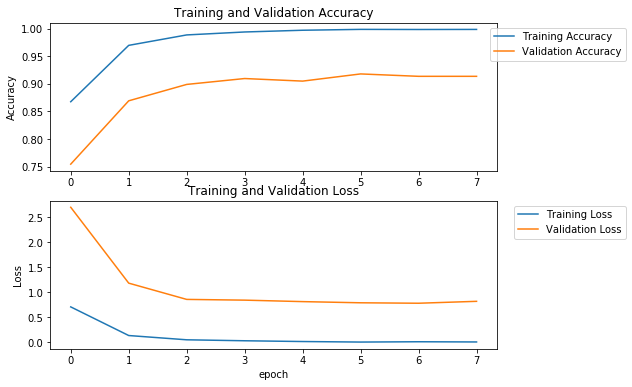

In [28]:
import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(bbox_to_anchor=(1.3, 1),loc='upper right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(bbox_to_anchor=(1.3, 1),loc='upper right')
plt.ylabel('Loss')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


**Observations:**
1. There is some overfitting in the model
2. But the overfitting is not very severe

## Plotting confusion matrix

In [27]:
model.save('resnetModel2.h5')

In [29]:
new_model = tf.keras.models.load_model('resnetModel2.h5')

In [30]:
predictionsV = new_model.predict(x=valid_batches, steps=len(valid_batches), verbose=0)

In [31]:
scores = new_model.evaluate(valid_batches, verbose=0)
print("%s: %.2f%%" % (new_model.metrics_names[1], scores[1]*100))

  ...
    to  
  ['...']
acc: 91.37%


**Observations:**
1. After training, the model is saved to an h5 file.
2. The validation accuracy is 91.37%

In [32]:
cm = confusion_matrix(y_true=valid_batches.classes, y_pred=predictionsV.argmax(axis=1))

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 49  75  72  90  69  82]
 [ 68  70  65  90  92  89]
 [ 81  96  75 125  77  99]
 [ 75  78  79 104  95  94]
 [ 65  84  83 101  93  84]
 [ 67  77  80 100  86  91]]


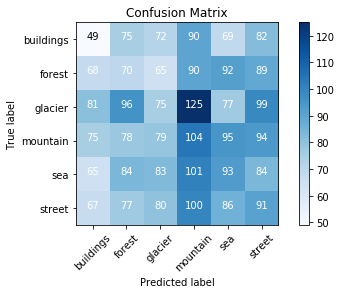

In [34]:
cm_plot_labels = ['buildings','forest','glacier','mountain','sea','street']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

**Observations:**
1. The confusion matrix show performance of all classes.
2. Many images are predicted as mountain even if they belong to other classes.

## Prediction on test images

In [35]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [36]:
test_batches.filenames[:5]

['unknown\\101.jpg',
 'unknown\\103.jpg',
 'unknown\\11.jpg',
 'unknown\\110.jpg',
 'unknown\\117.jpg']

In [37]:
preds_cls_idx = predictions.argmax(axis=-1)

In [38]:
# https://stackoverflow.com/questions/57516673/how-to-perform-prediction-using-predict-generator-on-unlabeled-test-data-in-kera
import numpy as np
idx_to_cls = {v: k for k, v in train_batches.class_indices.items()}
preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx)
filenames_to_cls = list(zip(test_batches.filenames, preds_cls))

In [39]:
train_batches.class_indices.items()

dict_items([('buildings', 0), ('forest', 1), ('glacier', 2), ('mountain', 3), ('sea', 4), ('street', 5)])

In [40]:
filenames_to_cls[:5]

[('unknown\\101.jpg', 'glacier'),
 ('unknown\\103.jpg', 'buildings'),
 ('unknown\\11.jpg', 'glacier'),
 ('unknown\\110.jpg', 'mountain'),
 ('unknown\\117.jpg', 'street')]

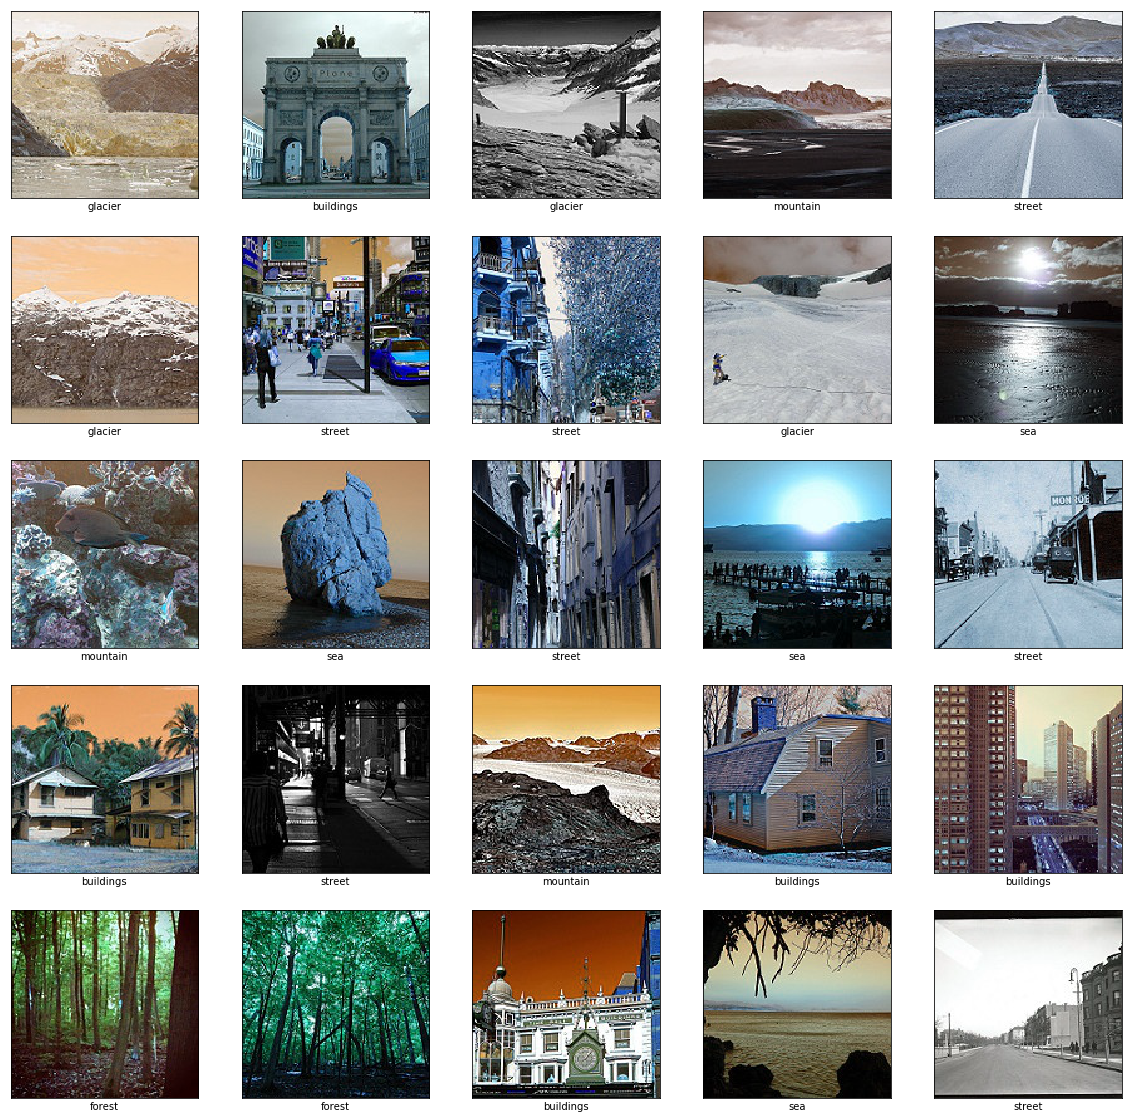

In [41]:
import cv2 as cv
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = cv.imread(r'Dataset - Large\\seg_pred\\'+filenames_to_cls[i][0])
    plt.imshow(img)
    plt.xlabel(filenames_to_cls[i][1])
plt.show()


**Observations:**
1. The class labels for test images is not given. Hence we cant calculate its accuracy.
2. The results on test batches are quite good.
3. The classes in this dataset are very similar to classes in imagenet dataset, hence just by retraining last few layers, ResNet50 model has given very good performance on test set
4. Most of the predictions on test images are correct.